In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg import (
    HeisenbergModel,
    HeisenbergModelGPU,
    get_graph,
    get_positions,
    # get_initial_layout,
    # get_prob0,
)
from setup import setup_backend
from helper_features import run_job, get_features
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector, entropy, partial_trace
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
)

# matrix product state simulator
backend_qpu, backend_mps_noiseless, backend_mps_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="matrix_product_state"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['id', 'sx', 'measure', 'reset', 'x', 'cz']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2

In [7]:
# n_qubits = 52
# t = 1.0
# n_step = 6

# # define the Heisenberg model
# Js = [1.0] * (n_qubits - 1)
# G = get_graph(n_qubits, Js)

# heisenberg = HeisenbergModel(n_qubits, G)

# circuit = heisenberg.get_circuit(total_time=t, n_step=n_step, phase=0)
# circuit.draw(output="mpl", fold=-1)

depth: 89
ops: OrderedDict([('cx', 646), ('rx', 298), ('rz', 298), ('rzx', 298), ('measure', 52), ('h', 2), ('barrier', 1)])


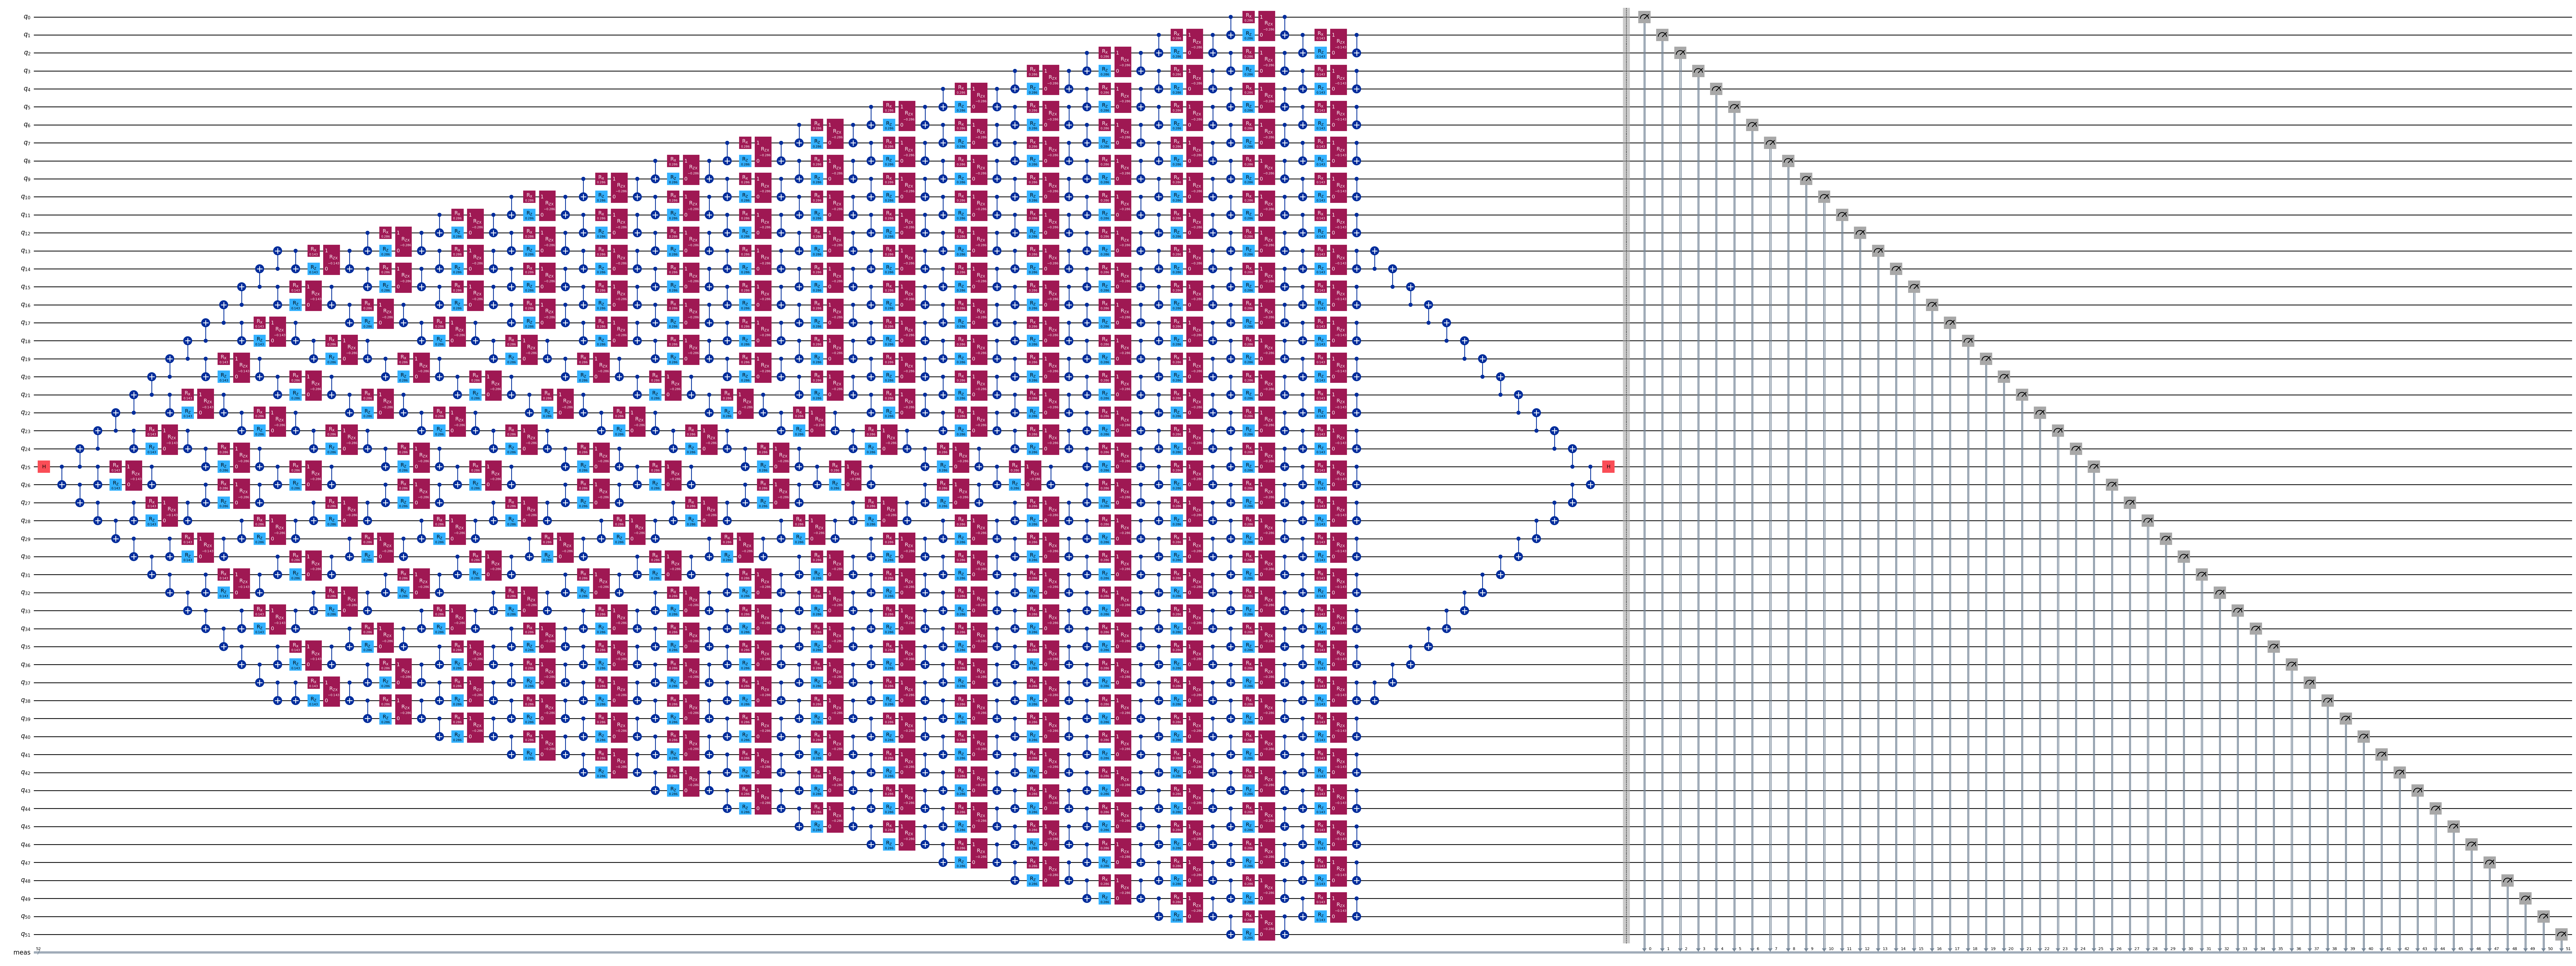

In [21]:
n_qubits = 52
t = 1.0
n_step = 7

# define the Heisenberg model
Js = [1.0] * (n_qubits - 1)
G = get_graph(n_qubits, Js)

heisenberg = HeisenbergModelGPU(n_qubits, G)

circuit = heisenberg.get_circuit(total_time=t, n_step=n_step, phase=0)
# circuit.remove_final_measurements()
print(f"depth: {circuit.depth()}")
print(f"ops: {circuit.count_ops()}")
circuit.draw(output="mpl", fold=-1)

-> $n_{\text{step}}$ は最大 7 まで設定する

In [ ]:
n_samples = 10
rng = np.random.default_rng(42)
entropies = {}

for i in range(n_samples):
    print(f"sample {i}/{n_samples}")
    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModelGPU(n_qubits, G)
    circuit = heisenberg.get_circuit(total_time=t, n_step=n_step, phase=0)

    circuit.remove_final_measurements()
    all_state = Statevector(circuit)
    entropies[i] = []
    for j in range(n_qubits):
        trace_qubits = [k for k in range(n_qubits) if k != j]
        half_state = partial_trace(all_state, trace_qubits)
        entropies[i].append(entropy(half_state, base=2))

sample 0/10
sample 1/10
sample 2/10
sample 3/10
sample 4/10
sample 5/10
sample 6/10
sample 7/10
sample 8/10
sample 9/10


In [ ]:
# DataFrame に変換。行がサンプル、列が qubit index
df = pd.DataFrame.from_dict(entropies, orient="index")
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.391081e-06,2.442707e-04,0.196811,0.196875,0.001977,0.202225,0.000048,0.004073,0.207497,0.207455,0.000178,2.416487e-07
1,2.383400e-05,1.403928e-03,0.197366,0.197844,0.000251,0.130365,0.000023,0.001223,0.045979,0.045595,0.000804,1.770702e-06
2,3.245507e-05,2.549938e-03,0.102451,0.103601,0.001622,0.093628,0.000004,0.000507,0.083311,0.081978,0.002773,5.501672e-06
3,4.120751e-07,1.649216e-04,0.250820,0.250860,0.014052,0.266115,0.000005,0.000679,0.280868,0.278946,0.005607,3.205753e-05
4,3.943792e-06,4.966523e-04,0.028210,0.028466,0.000257,0.085351,0.000046,0.006130,0.132240,0.131922,0.000894,2.915013e-06
5,3.600941e-07,2.754671e-05,0.026717,0.026713,0.001430,0.149764,0.000038,0.000755,0.240477,0.239500,0.002895,1.913091e-06
6,1.795373e-06,4.314461e-03,0.325244,0.326565,0.000534,0.312263,0.000082,0.006275,0.297480,0.295971,0.004691,2.049545e-05
7,5.628151e-07,2.155666e-04,0.164259,0.164324,0.001448,0.226985,0.000221,0.017454,0.281657,0.280097,0.004827,9.481213e-07
8,2.854737e-09,2.494974e-07,0.257955,0.257955,0.003948,0.171634,0.000003,0.000371,0.059905,0.058352,0.002916,5.064745e-05
9,1.810215e-05,1.503402e-03,0.059487,0.060223,0.000550,0.067495,0.000007,0.000042,0.074557,0.073671,0.001864,1.741787e-05


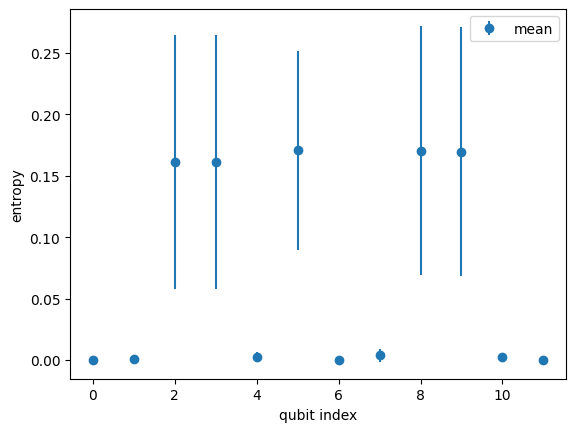

In [41]:
# error bar を plot
entropies_mean = df.mean()
entropies_std = df.std()
plt.errorbar(range(n_qubits), entropies_mean, yerr=entropies_std, fmt="o")
plt.legend(["mean", "std"])
plt.xlabel("qubit index")
plt.ylabel("entropy")
plt.show()

In [26]:
%%time
n_shots = 100

exec_circuit = transpile(circuit, backend_mps_noisy, optimization_level=3)
sampler = Sampler(mode=backend_mps_noisy)
job = sampler.run([exec_circuit, exec_circuit], shots=n_shots)
print("job Done")

result = job.result()

job Done
CPU times: user 1h 33min 35s, sys: 36min 6s, total: 2h 9min 41s
Wall time: 2min 42s


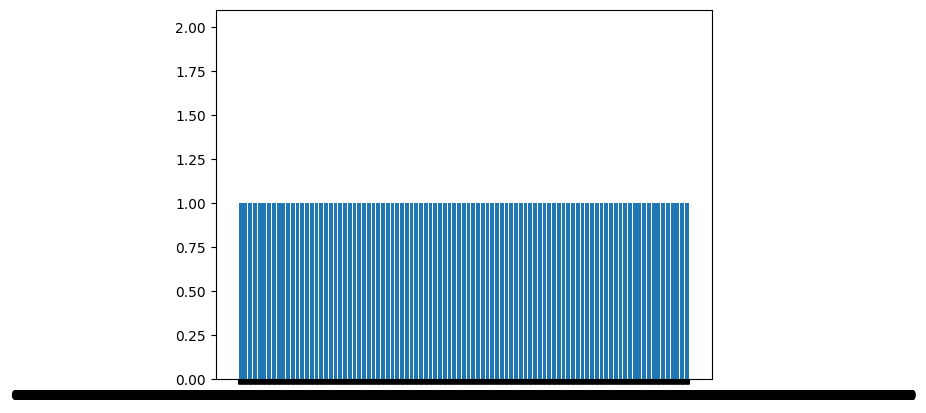

In [25]:
plt.bar(
    result[0].data.meas.get_counts().keys(), result[0].data.meas.get_counts().values()
)
plt.show()

In [17]:
# Plot
plt.bar(range(n_qubits), result.get_counts(0).mean(axis=0))

AttributeError: 'PrimitiveResult' object has no attribute 'get_counts'

In [18]:
result = job.result()

In [ ]:
# result = job[0].result()

In [ ]:
meas_counts = result.data.meas.get_counts()
num_shots = result.data.meas.num_shots

prob0 = meas_counts.get("0" * n_qubits, 0) / num_shots